# IMPORT PACKAGES

In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import vector_tools as vt
#import khFunctions as khf
%matplotlib ipympl
from datetime import timedelta
import re

# IMPORT, FLAG, AND CLEAN DATA

In [2]:
#Use .dat, .vhd. and .sen files to generate a dataset that matches format used by 
#Wheeler and Giddings 2023 to be usable in their functions
datfile1 = 'ADV/DEP204.dat'
vhdfile1 = 'ADV/DEP204.vhd'
senfile1 = 'ADV/DEP204.sen'

datfile2 = 'ADV/DEP205.dat'
vhdfile2 = 'ADV/DEP205.vhd'
senfile2 = 'ADV/DEP205.sen'

fs = 32

#Create the raw dataset 
adv1 = vt.vector_to_ds(datfile1, vhdfile1, senfile1, fs)

#Flag the raw dataset
adv1_flagged = vt.vectorFlag(adv1)

#Trim the bad times during adv deployment and recovery
adv1_trimmed = adv1_flagged.sel(dict(time=slice('2022-08-02T11:00:00.000000000', '2022-08-11T11:00:00.000000000'),
                                     time_sen=slice('2022-08-02T11:00:00.000000000', '2022-08-11T11:00:00.000000000'),
                                     time_start=slice('2022-08-02T11:00:00.000000000', '2022-08-11T11:00:00.000000000')))

#Repeat with second deployment
adv2 = vt.vector_to_ds(datfile2, vhdfile2, senfile2, fs)
adv2_flagged = vt.vectorFlag(adv2)
adv2_trimmed = adv2_flagged.sel(dict(time=slice('2022-08-15T09:00:00.000000000', '2022-08-30T11:00:00.000000000'),
                                     time_sen=slice('2022-08-15T09:00:00.000000000', '2022-08-30T11:00:00.000000000'),
                                     time_start=slice('2022-08-15T09:00:00.000000000', '2022-08-30T11:00:00.000000000')))

#Add in metadata from .hdr file and project information

headerFile1 = 'ADV/DEP204.hdr'
headerFile2 = 'ADV/DEP205.hdr'
metadata_list = [('Creator', 'Logan A. Grady'), ('Contact information', 'logan.grady@sjsu.edu'), ('Description', 'ADV deployed in Stillwater Cove, recording ENU velocity at 32Hz'),
 ('Lat', 36.56195999999164), ('Lon', -121.94174126537672)]

ds1_cleaned = vt.vector_metadata(adv1_trimmed, headerFile1, metadata_list)
ds2_cleaned = vt.vector_metadata(adv2_trimmed, headerFile2, metadata_list)

Importing data
Creating timelines
Creating xarray dataset
Assigning dataset attributes
Flagging data
Flagging sensor data
Importing data
Creating timelines
Creating xarray dataset
Assigning dataset attributes
Flagging data
Flagging sensor data


In [8]:
#Export usable data
ds1_cleaned.to_netcdf('ADV/adv1All.nc')
ds2_cleaned.to_netcdf('ADV/adv2All.nc')

In [3]:
#Look at raw adv data
vecDS = adv1.copy(deep=True)
East = vecDS.East.resample(time='20Min').mean().dropna(dim = 'time')
North = vecDS.North.resample(time='20Min').mean().dropna(dim = 'time')
Press = vecDS.Pressure.resample(time='20Min').std().dropna(dim = 'time')

In [18]:
def adv_qc_plot(vecData):
    vecDS = vecData.copy(deep=True)
    Cavg = (vecDS.Corr1 + vecDS.Corr2 + vecDS.Corr3)/3

    fig, axs = plt.subplots(5,1,constrained_layout=True, figsize = (15,12))
    
    axs[0].set_title('Eastern Velocity')
    axs[0].plot(vecDS.time, vecDS.East, '.b')
    axs[0].axhline(y=0, c = 'black', ls = '--')
    axs[0].set_ylabel('Velocity [m/s]')
    axs[0].margins(x=.01)

    axs[1].set_title('Average Beam Correlation')
    axs[1].plot(vecDS.time, Cavg, '.r')
    axs[1].set_ylabel('Correlation (%)')
    axs[1].margins(x=.01)

    axs[2].set_title('Instrument Tilt')
    axs[2].plot(vecDS.time_sen, vecDS.Pitch, '.k', label = 'Pitch')
    axs[2].plot(vecDS.time_sen, vecDS.Roll, '.g', label = 'Roll')
    axs[2].set_ylabel('Degrees')
    axs[2].margins(x=.01)
    axs[2].legend(loc = 'upper left')

    axs[3].set_title('Battery Voltage')
    axs[3].plot(vecDS.time_sen, vecDS.BatVolt, '.y')
    axs[3].set_ylabel('Voltage')
    axs[3].margins(x=.01)

    axs[4].set_title('Flag Score (1 = Pass, 3 = Suspect, 4 = Fail, 9 = Critical Fail)')
    axs[4].plot(vecDS.time, vecDS.DataFlag, '.r', label = 'Velocity Data Flag')
    axs[4].plot(vecDS.time_sen, vecDS.SenFlag, '.b', label = 'Sensor Data Flag')
    axs[4].set_ylabel('Grade (1-9)')
    axs[4].set_xlabel('Date')
    axs[4].margins(x=.01)
    axs[4].set_ylim(0,10)
    axs[4].set_yticks([1,3,4,9])
    axs[4].legend(loc = 'upper left')

In [9]:
#Import usable data
adv1 = xr.open_dataset('ADV/adv1All.nc')
adv2 = xr.open_dataset('ADV/adv2All.nc')

# DESPIKING DATA

In [ ]:
#Despike adv data using the expanding ellipsoid method from Wheeler & Giddings 2023

#Conditions
badSections = [] #Bad sectiions already removed during data import
reverse = False #Set variable for reversing direction after rotation if needed

#Run expanding threshold despiking algorith and clean data with bad SNR/Correlation
adv1Despiked = vt.ProcessVec(ds1_cleaned, 32, badSections,reverse,expand = True,lp = 1/20,expSize = 0.01,expEnd = 0.95)
adv2Despiked = vt.ProcessVec(ds2_cleaned, 32, badSections,reverse,expand = True,lp = 1/20,expSize = 0.01,expEnd = 0.95)

#'ProcessVec' function from Wheeler & Giddings has been modified to work with my dataset
#but the core algorithm remains unchanged

#Export despiked data
adv1Despiked.to_netcdf('ADV/adv1_despiked.nc')
adv2Despiked.to_netcdf('ADV/adv2_despiked.nc')

# Repairing data gaps
- Three methods
    - Full linear interpolation across all gaps
    - Partial interpolation over gaps <= 1s and averaging longer gaps with the average of the removed data
    - Partial interpolation over gaps <= 1s and patching longer gaps

In [5]:
#Import despiked data
adv1Despiked = xr.open_dataset('ADV/adv1Despiked.nc')
adv2Despiked = xr.open_dataset('ADV/adv2Despiked.nc')

In [16]:
adv1Despiked.EOrig.where((adv1Despiked.Corr1 < 50) &
                         (adv1Despiked.Corr2 < 50) &
                         (adv1Despiked.Corr3 < 50)).dropna(dim = 'time', how = 'all')

<xarray.DataArray 'EOrig' ()>
array(1.)

In [18]:
trueEast = adv1Despiked.East.where(adv1Despiked.EOrig==True).dropna(dim = 'time', how = 'all')
falseEast = adv1Despiked.East.where(adv1Despiked.EOrig==False).dropna(dim = 'time', how = 'all')

In [29]:
adv1Despiked

<xarray.Dataset>
Dimensions:        (time_start: 216, time_sen: 259416, time: 8294400, burst: 216)
Coordinates:
  * time           (time) datetime64[ns] 2022-08-02T11:40:00 ... 2022-08-11T1...
  * time_sen       (time_sen) datetime64[ns] 2022-08-02T11:00:00 ... 2022-08-...
  * time_start     (time_start) datetime64[ns] 2022-08-02T11:40:00 ... 2022-0...
  * burst          (burst) int64 3 4 5 6 7 8 9 ... 212 213 214 215 216 217 218
Data variables: (12/46)
    BurstCounter   (time_start) int64 3 4 5 6 7 8 9 ... 213 214 215 216 217 218
    NoVelSamples   (time_start) int64 38400 38400 38400 ... 38400 38400 38400
    ErrorCode      (time_sen) int64 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    StatusCode     (time_sen) int64 1110001 1110001 1110001 ... 1110001 1110001
    BatVolt        (time_sen) float64 13.5 13.5 13.6 13.6 ... 11.1 11.1 11.1
    SoundSpeed     (time_sen) float64 1.505e+03 1.505e+03 ... 1.497e+03
    ...             ...
    UpRaw          (time) float64 -0.007 -0.008 -0.007 ... -0.003 -0.003 -0.002
    dEast          (burst) float64 0.004974 0.008385 0.004714 ... 0.3217 0.09404
    dNorth         (burst) float64 0.003203 0.005885 0.00612 ... 0.3222 0.09641
    dUp            (burst) float64 0.00888 0.01448 0.00849 ... 0.3227 0.09737
    dPrimary       (burst) float64 0.007448 0.0125 0.009036 ... 0.3242 0.09836
    dSecondary     (burst) float64 0.007448 0.0125 0.009036 ... 0.3242 0.09836
Attributes: (12/48)
    description:                                           First deployment o...
    lat:                                                   36.56195999999164
    lon:                                                   -121.94174126537672
    CorrCutoff:                                            60
    SnrCutoff:                                             10
    AngleCutoff:                                           10000
    ...                                                    ...
    Number of beams:                                       3
    Software version:                                      1.39.09
    Deployment name:                                       depl_2
    Wrap mode:                                             OFF
    Deployment time:                                       8/2/2022 9:40:00 AM
    Comments:                                              Second deployment ...

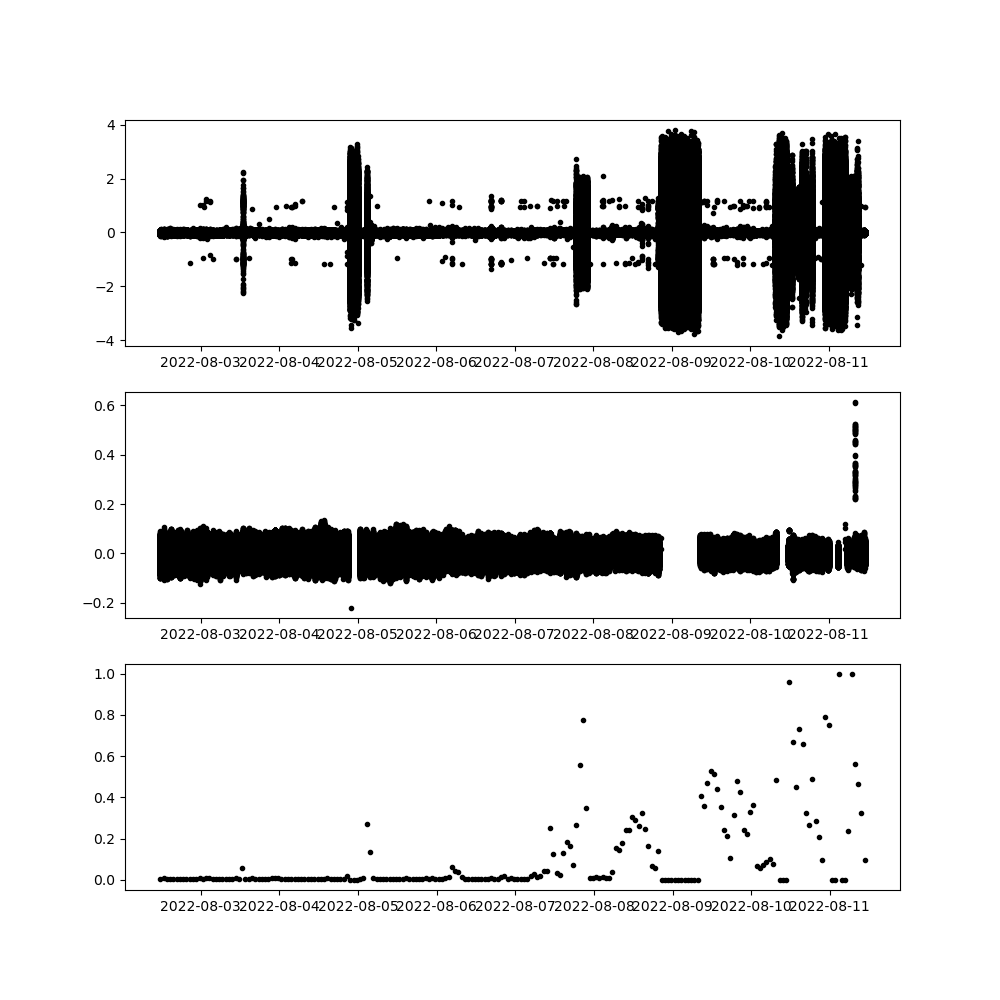

In [33]:
plt.figure(figsize = (10,10))
plt.subplot(311)
plt.plot(adv1Despiked.time, adv1Despiked.EastRaw, '.k')

plt.subplot(312)
plt.plot(adv1Despiked.time, adv1Despiked.East, '.k')

plt.subplot(313)
plt.plot(adv1Despiked.time_start, adv1Despiked.dEast, '.k')

plt.show()

In [ ]:
#copy to not modify in place
v = vector.copy(deep=True)

#initialize index
index = np.zeros(np.shape(v.time.values),dtype='bool')

#find where correlation cutoff fails
index[np.logical_or(np.logical_or(v.Corr1.values < corrCutoff, \
                             v.Corr2.values < corrCutoff), \
                             v.Corr3.values < corrCutoff)] = True

#find where snr cutoff fails
index[np.logical_or(np.logical_or(v.Snr1.values < snrCutoff, \
                             v.Snr2.values < snrCutoff), \
                             v.Snr3.values < snrCutoff)] = True

#if angle is too big, assume we don't have trustworthy tilt information
if np.abs(angleCutoff) < 2*np.pi:

    #get pitch and roll info on correct timestep
    pitch = v.Pitch.interp(time_sen = v.time.values).values
    roll = v.Roll.interp(time_sen=v.time.values).values

    #convert pitch and roll to total tilt
    tilt = np.arctan(np.sqrt(np.tan(pitch*2*np.pi/360)**2+np.tan(roll*2*np.pi/360)**2))

    #find where angle cutoff fails
    index[tilt>angleCutoff] = True

In [22]:
#Full linear interpolation of gaps
adv1Int = vt.fullInterpVec(adv1Despiked)
adv2Int = vt.fullInterpVec(adv2Despiked)

Linearly interpolating dataset
Evaluating ratio of nans leftover in the dataset
Linearly interpolating dataset
Evaluating ratio of nans leftover in the dataset


In [8]:
#Inerpolate gaps <= 1s and and patch the remaining gaps
adv1Patch = vt.patchVec(adv1Despiked)
adv2Patch = vt.patchVec(adv2Despiked)

Interpolating gaps <= 1s
Evaluating ratio of nans leftover in the dataset
Interpolating gaps <= 1s
Evaluating ratio of nans leftover in the dataset


In [ ]:
#Interpolate gaps <= 1s and average the remaining gaps
adv1IntAvg = vt.interpAvgVec(adv1Despiked)
adv2IntAvg = vt.interpAvgVec(adv2Despiked)

# Wavenumber integral Jlm
- Takes equation A13 from Gerbi et al. (2009) and applies it to the despiked and repaired datasets

In [ ]:
#Calculate the wavenumber integral for all datasets
Jlm1Int = vt.JlmIntegral(adv1Int)
Jlm2Int = vt.JlmIntegral(adv2Int)
Jlm1Patch = vt.JlmIntegral(adv1Patch)
Jlm2Patch = vt.JlmIntegral(adv2Patch)
Jlm1IntAvg = vt.JlmIntegral(adv1IntAvg)
Jlm2IntAvg = vt.JlmIntegral(adv2IntAvg)

In [2]:
#Add Jlm to corresponding datasets

#For deployment 1 data
adv1Int['J33'] = Jlm1Int['J_33']
adv1Patch['J33'] = Jlm1Patch['J_33']
adv1IntAvg['J33'] = Jlm1IntAvg['J_33']

#For deployment 2 data
adv2Int['J33'] = Jlm1Int['J_33']
adv2Int['J33'] = Jlm2Patch['J_33']
adv2IntAvg['J33'] = Jlm2IntAvg['J_33']

In [4]:
#Export the Organized, cleaned, despiked, gap-repaired datasets with wavenumber integrals included
adv1Int.to_netcdf('ADV/adv1Int.nc')
adv2Int.to_netcdf('ADV/adv2Int.nc')

adv1Patch.to_netcdf('ADV/adv1Patch.nc')
adv2Patch.to_netcdf('ADV/adv2Patch.nc')

adv1IntAvg.to_netcdf('ADV/adv1IntAvg.nc')
adv2IntAvg.to_netcdf('ADV/adv2IntAvg.nc')

In [2]:
#Import deployment 1 data
adv1Int = xr.open_dataset('ADV/adv1_Interp.nc')
adv1Int['J33'] = (['burst'], pd.read_csv('ADV/Jlm1Int.csv').J_33)
adv1Patch = xr.open_dataset('ADV/adv1_Patched.nc')
adv1Patch['J33'] = (['burst'], pd.read_csv('ADV/Jlm1Patch.csv').J_33)
adv1IntAvg = xr.open_dataset('ADV/adv1_IntAverage.nc')
adv1IntAvg['J33'] = (['burst'], pd.read_csv('ADV/Jlm1IntAvg.csv').J_33)

#Import deployment 2 data
adv2Int = xr.open_dataset('ADV/adv2_Interp.nc')
adv2Int['J33'] = (['burst'], pd.read_csv('ADV/Jlm2Int.csv').J_33)
adv2Patch = xr.open_dataset('ADV/adv2_Patched.nc')
adv2Int['J33'] = (['burst'], pd.read_csv('ADV/Jlm2Patch.csv').J_33)
adv2IntAvg = xr.open_dataset('ADV/adv2_IntAverage.nc')
adv2IntAvg['J33'] = (['burst'], pd.read_csv('ADV/Jlm2IntAvg.csv').J_33)

## If phase wrapping is present
- Convert velocities from ENU to beam by using the transformation matrix in .hdr files
    - The following code is based on a MatLab script available on NORTEK's FAQ forums:
        https://support.nortekgroup.com/hc/en-us/articles/360029820971-How-is-a-coordinate-transformation-done-
        - Most relevant information is available in the .hdr file
        - You will need the transformation matrix, as well as heading, pitch, and roll data for each sample to make the conversions
    - Once velocities have been converted, calculate the ambiguous velocity V_amb
    - Run a patch over the entire BEAM velocity dataset
        - If phase wrap is negative: newvel = oldvel + 2*V_amb
        - If phase wrap is positive: newvel = oldvel - 2*V_amb
    -Convert patched velocities back to ENU for more user-friendly data

In [52]:
# Transformation matrix located in .hdr file as 'Transformation matrix'

T = np.array([[2.7249, -1.3770, -1.3503], #Convert matrix to multidimensional numpy array
   [-0.0161, 2.3442, -2.3308],
   [0.3472, 0.3455, 0.3389]])

# Heading, pitch and roll are the angles output in the data in degrees
# Convert to radians
hh = np.pi*(adv1_flagged['Heading']-90)/180 #Creates list of hh, pp, and rr for all datapoints
pp = np.pi * (adv1_flagged['Pitch']/180)
rr = np.pi * (adv1_flagged['Roll']/180)

# Generate empty arrays to be populated by resulting beam velocities
beam1 = np.empty(len(adv1_flagged)) # Already created to be the length of the dataset to save processing time
beam2 = np.empty(len(adv1_flagged))
beam3 = np.empty(len(adv1_flagged))

In [ ]:
# Calculate heading matrix and tilt matrix for each data point and convert ENU velocities to beam velocities

# for loop iterates for each data point
for i in range(0,len(adv1_flagged)):
    if i % 1000000 == 0: # Progress check every 1000000 rows
                print('Currently on row:', i)
            
    H = np.array([[np.cos(hh[i]), np.sin(hh[i]), 0], # Makes the heading matrix for row i
                  [-np.sin(hh[i]), np.cos(hh[i]), 0], 
                  [0, 0, 1]])
    
    P = np.array([[np.cos(pp[i]), -np.sin(pp[i])*np.sin(rr[i]), -np.cos(rr[i])*np.sin(pp[i])], # Makes the tilt matrix for row i
                  [0, np.cos(rr[i]), -np.sin(rr[i])], 
                  [np.sin(pp[i]), np.sin(rr[i])*np.cos(pp[i]), np.cos(pp[i])*np.cos(rr[i])]])
    
    R = H*P*T #Product of transformation, heading, and tilt matrix creates conversion matrix R

    # Retrieves ENU velocities from row i to be converted by R[i]
    enu = np.array([adv1_flagged['Velocity_East(m/s)'][i], adv1_flagged['Velocity_North(m/s)'][i], adv1_flagged['Velocity_Up(m/s)'][i]])
    
    beam1[i] = np.dot(np.linalg.inv(R),enu)[0]
    beam2[i] = np.dot(np.linalg.inv(R),enu)[1]
    beam3[i] = np.dot(np.linalg.inv(R),enu)[2]

### Calculate v_amb
 - v_amb = VR * 2
 - VR = c/(4 * f * tlag(s))
 - c = 1530 (speed of sound measured by instrument)
 - f = instrument frequency (6000kHz)
 - tlag (for vector) = 50/480000 (50 is from system 38 in .hdr file, which indicates nominal velocity of 1m/s)